

## *Data Science Unit 4 Sprint 3 Assignment 2*
# Convolutional Neural Networks (CNNs)

# Assignment

- <a href="#p1">Part 1:</a> Pre-Trained Model
- <a href="#p2">Part 2:</a> Custom CNN Model
- <a href="#p3">Part 3:</a> CNN with Data Augmentation


You will apply three different CNN models to a binary image classification model using Keras. Classify images of Mountains (`./data/train/mountain/*`) and images of forests (`./data/train/forest/*`). Treat mountains as the positive class (1) and the forest images as the negative (zero). 

|Mountain (+)|Forest (-)|
|---|---|
|![](https://github.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/module2-convolutional-neural-networks/data/train/mountain/art1131.jpg?raw=1)|![](https://github.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/module2-convolutional-neural-networks/data/validation/forest/cdmc317.jpg?raw=1)|

The problem is relatively difficult given that the sample is tiny: there are about 350 observations per class. This sample size might be something that you can expect when prototyping an image classification problem/solution at work. Get accustomed to evaluating several different possible models.

# Pre - Trained Model
<a id="p1"></a>

Load a pretrained network from Keras, [ResNet50](https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1) - a 50 layer deep network trained to recognize [1000 objects](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt). Starting usage:

```python
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model # This is the functional API

resnet = ResNet50(weights='imagenet', include_top=False)

```

The `include_top` parameter in `ResNet50` will remove the full connected layers from the ResNet model. The next step is to turn off the training of the ResNet layers. We want to use the learned parameters without updating them in future training passes. 

```python
for layer in resnet.layers:
    layer.trainable = False
```

Using the Keras functional API, we will need to additional additional full connected layers to our model. We we removed the top layers, we removed all preivous fully connected layers. In other words, we kept only the feature processing portions of our network. You can expert with additional layers beyond what's listed here. The `GlobalAveragePooling2D` layer functions as a really fancy flatten function by taking the average of each of the last convolutional layer outputs (which is two dimensional still). 

```python
x = resnet.output
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(resnet.input, predictions)
```

Your assignment is to apply the transfer learning above to classify images of Mountains (`./data/train/mountain/*`) and images of forests (`./data/train/forest/*`). Treat mountains as the positive class (1) and the forest images as the negative (zero). 

Steps to complete assignment: 
1. Load in Image Data into numpy arrays (`X`) 
2. Create a `y` for the labels
3. Train your model with pre-trained layers from resnet
4. Report your model's accuracy

-----

# GPU on Colab

If you're working on Colab, you only have access to 2 processors so your model training will be slow. However, if you turn on the GPU instance that you have access to then you're model training will be faster! 

[**Instructions for turning on GPU on Colab**](https://colab.research.google.com/notebooks/gpu.ipynb)

------

## Load in Data

This surprisingly more difficult than it seems, because you are working with directories of images instead of a single file. 

This boiler plate will help you download a zipped version of the directory of images. The directory is organized into **train** and **validation** directories which you can use inside an `ImageGenerator` class to stream batches of images through your model.  



In [1]:
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt

import tensorflow as tf
import os

import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model # This is the functional API

from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

from tensorflow.keras.callbacks import EarlyStopping

from keras.preprocessing.image import array_to_img, img_to_array, load_img

In [2]:
%matplotlib inline
%load_ext tensorboard

In [3]:
# Clear any tensorboard logs from previous runs
!rm -rf ./logs/

### Download & Summarize the Data

This step is completed for you. Just run the cells and review the results. 

In [4]:
# data url
_URL = 'https://github.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/module2-convolutional-neural-networks/data.zip?raw=true'

# download data and save to `file_name`
file_name = './data.zip'
path_to_zip = tf.keras.utils.get_file(file_name, origin=_URL, extract=True)

# get absolute path to location of the data that we just downloaded
PATH = os.path.join(os.path.dirname(path_to_zip), 'data')

In [5]:
# protip: go to your terminal and paste the output below and cd into it
# explore it a bit...we'll come back to this later - muahahaha!!!
PATH

'/Users/nsriniva/.keras/datasets/./data'

In [6]:
# create train data dir path
train_dir = os.path.join(PATH, 'train')

# create validation data dir path
validation_dir = os.path.join(PATH, 'validation')

In [7]:
# train directory with mountian data sub-dir 
train_mountain_dir = os.path.join(train_dir, 'mountain') 

# train directory with forest data sub-dir 
train_forest_dir = os.path.join(train_dir, 'forest')  

# validation directory with mountain data sub-dir 
validation_mountain_dir = os.path.join(validation_dir, 'mountain')  

# validation directory with forest data sub-dir 
validation_forest_dir = os.path.join(validation_dir, 'forest')  

In [8]:
# get the number of samples in each of the sub-dir 
num_mountain_tr = len(os.listdir(train_mountain_dir))
num_forest_tr = len(os.listdir(train_forest_dir))

num_mountain_val = len(os.listdir(validation_mountain_dir))
num_forest_val = len(os.listdir(validation_forest_dir))

# get the total numnber of sample for the train and validation sets
total_train = num_mountain_tr + num_forest_tr
total_val = num_mountain_val + num_forest_val

In [9]:
print('total training mountain images:', num_mountain_tr)
print('total training forest images:', num_forest_tr)

print('total validation mountain images:', num_mountain_val)
print('total validation forest images:', num_forest_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training mountain images: 254
total training forest images: 270
total validation mountain images: 125
total validation forest images: 62
--
Total training images: 524
Total validation images: 187


---

### Keras `ImageGenerator` to Process the Data

This step is completed for you, but please review the code. The `ImageGenerator` class reads in batches of data from a directory and pass them to the model one batch at a time. Just like large text files, this method is advantageous, because it stifles the need to load a bunch of images into memory. 

**Check out the documentation for this class method:** [**Keras ImageGenerator Class**](https://keras.io/preprocessing/image/#imagedatagenerator-class). You'll expand it's use in the next section.

In [10]:
batch_size = 16
epochs = 10 # feel free to change this value only after you've gone through the notebook once  
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator can rescale data from within 
max_pixel_val = 255.
rescale = 1./max_pixel_val

# Generator for our training data
train_image_generator = ImageDataGenerator(rescale=rescale) 
                                           
# Generator for our validation data                                           
validation_image_generator = ImageDataGenerator(rescale=rescale) 

In [12]:
# Takes the path to a directory & generates batches of augmented data
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary', 
                                                           color_mode='rgb')

Found 533 images belonging to 2 classes.


In [13]:
# explore some of `train_data_gen` attributes to get a sense of what this object can do for you
train_data_gen.image_shape

(224, 224, 3)

In [14]:
# Takes the path to a directory & generates batches of augmented data
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary', 
                                                              color_mode='rgb')

Found 195 images belonging to 2 classes.


In [15]:
# explore some of `val_data_gen` attributes to get a sense of what this object can do for you


_____
## Instantiate Model

Here your job is to take the python code in the beginning of the notebook (in the markdown cell) and turn it into working code. 

Most of the code that you'll need to build a model is in that markdown cell, though you'll still need to compile the model.

Some pseudo-code is provided as guide. 

In [16]:
# load in the pre-trained model
# YOUR CODE HERE

resnet = ResNet50(weights='imagenet', include_top=False)




In [17]:
# YOUR CODE HERE
for layer in resnet.layers:
    layer.trainable = False


In [18]:
# take the model output layer as a starting point
x = resnet.output

# take a global average pool
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten

# add a trainable hidden layer with 1024 nodes 
x = Dense(1024, activation='relu')(x)

# add a trainable output layer 
predictions = Dense(1, activation='sigmoid')(x)

# put it all together using the Keras's Model api

model = Model(resnet.input, predictions)

# YOUR CODE HERE


In [19]:
# the only code that is missing is the complie method 

# YOUR CODE HERE

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


## Fit Model

In [20]:
# include the callback into the fit method
# we'll launch tensorboard in the last section
logdir = os.path.join("logs", "resnet_model")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [21]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    workers=14, # num should be 1 or 2 processors less than the total number of process on your machine
    callbacks=[tensorboard_callback]
)

Epoch 1/10
32/32 [==============================] - 26s 742ms/step - loss: 1.0809 - accuracy: 0.5216 - val_loss: 0.6144 - val_accuracy: 0.7727
Epoch 2/10
32/32 [==============================] - 23s 717ms/step - loss: 0.6181 - accuracy: 0.6715 - val_loss: 0.5381 - val_accuracy: 0.8068
Epoch 3/10
32/32 [==============================] - 23s 727ms/step - loss: 0.5630 - accuracy: 0.6692 - val_loss: 0.4773 - val_accuracy: 0.7386
Epoch 4/10
32/32 [==============================] - 23s 731ms/step - loss: 0.6301 - accuracy: 0.6422 - val_loss: 0.5035 - val_accuracy: 0.6818
Epoch 5/10
32/32 [==============================] - 23s 728ms/step - loss: 0.5692 - accuracy: 0.6856 - val_loss: 0.4111 - val_accuracy: 0.7898
Epoch 6/10
32/32 [==============================] - 23s 714ms/step - loss: 0.4442 - accuracy: 0.8192 - val_loss: 0.3923 - val_accuracy: 0.8920
Epoch 7/10
32/32 [==============================] - 23s 716ms/step - loss: 0.3636 - accuracy: 0.9136 - val_loss: 0.3832 - val_accuracy: 0.8864

## Take Away

The above task is an exercising in using a pre-trained model in the context of **Transfer Learning**. 

**Transfer Learning** happens when you take a model that was trained on data set $A$ and applying it on data set $B$ (you may or may not choose to re-train the model.)

We loaded in a pre-trained model (meaning the weight values have been optimized in a previous fit), and updated the value of the weights by re-training them. Note that we didn't reset the model weights, what we did was 
continue their training on a different dataset, our data set. 


-----
# Custom CNN Model

In this step, write and train your own convolutional neural network using Keras. You can use any architecture that suits you as long as it has at least one convolutional and one pooling layer at the beginning of the network - you can add more if you want. 

**Protip:** You'll be creating a 2nd instance of this same model in the next section. Instead of copying and pasting all this code, just embed it in a function called `def create_model()` that returns a complied model. 

Free free to reference the custom CNN model that we built together in the guided project. 

In [22]:
def create_model():
    """
    Since we'll using this model again in the next section, it's useful to create a function 
    that returns a complied model.
    """
    # YOUR CODE HERE
    model = Sequential()

    model.add(Conv2D(64, (3,3), activation='relu', input_shape=train_data_gen.image_shape))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(16, (3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(1024, activation='sigmoid'))

    model.add(Dense(1, activation='sigmoid'))
              
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [23]:
# instantiate a model 
model = create_model()

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 16)        4624      
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              4

In [25]:
# include this callback in your fit method
# we'll launch tensorboard in the last section
logdir = os.path.join("logs", "baseline_model")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [26]:
# Fit Model
epochs = 10
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    workers=14, # num should be 1 or 2 processors less than the total number of process on your machine 
    callbacks=[tensorboard_callback]
)

Epoch 1/10
32/32 [==============================] - 17s 513ms/step - loss: 1.4469 - accuracy: 0.6648 - val_loss: 0.2137 - val_accuracy: 0.9261
Epoch 2/10
32/32 [==============================] - 16s 495ms/step - loss: 0.1531 - accuracy: 0.9491 - val_loss: 0.3540 - val_accuracy: 0.8693
Epoch 3/10
32/32 [==============================] - 16s 500ms/step - loss: 0.1619 - accuracy: 0.9308 - val_loss: 0.2800 - val_accuracy: 0.8977
Epoch 4/10
32/32 [==============================] - 16s 495ms/step - loss: 0.1387 - accuracy: 0.9420 - val_loss: 0.5490 - val_accuracy: 0.8239
Epoch 5/10
32/32 [==============================] - 16s 500ms/step - loss: 0.1441 - accuracy: 0.9635 - val_loss: 0.3303 - val_accuracy: 0.8977
Epoch 6/10
32/32 [==============================] - 16s 505ms/step - loss: 0.1668 - accuracy: 0.9303 - val_loss: 0.4094 - val_accuracy: 0.8864
Epoch 7/10
32/32 [==============================] - 16s 497ms/step - loss: 0.0764 - accuracy: 0.9773 - val_loss: 0.1936 - val_accuracy: 0.9034

------
# Custom CNN Model with Image Manipulations

To simulate an increase in a sample of image, you can apply image manipulation techniques: cropping, rotation, stretching, etc. Luckily Keras has some handy functions for us to apply these techniques to our mountain and forest example. You should be able to modify our image generator for the problem. Check out these resources to help you get started: 

1. [**Keras ImageGenerator Class**](https://keras.io/preprocessing/image/#imagedatagenerator-class) documentation for the tool that we need to use to augment our images.
2. [**Building a powerful image classifier with very little data**](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) This is an essentially a tutorial on how to use the ImageGenerator class to create augmented images. You can essentially copy and paste the relevant code, though don't do that blindly! 
 

### Use ImageDataGenerator to create augmented data

Use explore the parameters for ImageDataGenerator that will enable you to generate augment version of images that we already have. Here are some of the relevant parameters to help you get started. 

- rescale
- shear_range
- zoom_range
- horizontal_flip

### Only create augmented images for the training data. 

We want to be able to do a comparison with the same CNN model (or models) from above. 

In order to do that, we will augment the training data but not the validation data. Then we'll compare the accuracy and loss on the validation set. 

That way we are comparing the performance of the same model architecture on the same test set, the only different will be the augmented training data. Therefore, we'll be in a position to determine if augmenting our training data actually helped improve our model performance. 

This is an example of a controlled experiment.

In [27]:
batch_size = 16

# ImageDataGenerator can rescale data from within 
max_pixel_val = 255.
rescale = 1./max_pixel_val

In [28]:
# YOUR CODE HERE
train_datagen_aug = ImageDataGenerator(
                                        rescale=rescale,
                                        rotation_range=10, # rotation
                                        width_shift_range=0.2, # horizontal shift
                                        height_shift_range=0.2, # vertical shift
                                        zoom_range=0.2, # zoom
                                        horizontal_flip=True, # horizontal flip
                                        brightness_range=[0.2,1.2]
                                    ) 

In [29]:
# call the .flow_from_directory() method - save result to `train_data_gen_aug`
# protip: be mindful of the parameters

# YOUR CODE HERE
train_data_gen_aug = train_datagen_aug.flow_from_directory(batch_size=batch_size,
                                                               directory=train_dir,
                                                               shuffle=True,
                                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               class_mode='binary', 
                                                               color_mode='rgb')

Found 533 images belonging to 2 classes.


### Augment a Single Image

Now that you have instantiate `ImageDataGenerator` object that created augmented images for the training set. Let's visual those augmented images to get a sense of what augmented images actually look like! 


In [30]:
# filename of image that we will augment
# this is just one of 100's of training images to choose from
# feel free to explore the training data directories and choose another image
# this image was selected from the mountain images 
img_to_aug = "art1131.jpg"

# replace with YOUR home directory name 
home_dir = "nsriniva"

# create absolute file path to image file
path_to_single_img = "/Users/{0}/.keras/datasets/data/train/mountain/{1}".format(home_dir, img_to_aug)
path_to_single_img

'/Users/nsriniva/.keras/datasets/data/train/mountain/art1131.jpg'

In [31]:
# load in image from file and reshape
img = load_img(path_to_single_img)  
x = img_to_array(img) 
x = x.reshape((1,) + x.shape)  

Create a temporary director to store the augmented images that we will create in order to visualize. 

In [32]:
# this is a terminal command that we are running in the notebook by including a `!` 
# feel free to delete this temp dir after visualizing the aug images below
# you only need to create this dir once
!mkdir preview_img

Use the training data generator that we just created in order to create 20 augmented images of the same original image.

In [33]:
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview_img` directory

# create 20 aug images
n_aug_imgs_to_create = 20
i = 0
for batch in train_datagen_aug.flow(x, 
                                    batch_size=1,
                                    save_to_dir='preview_img', 
                                    save_prefix='art', 
                                    save_format='jpeg'):
    i += 1
    if i > n_aug_imgs_to_create:
        break  # otherwise the generator would loop indefinitely

In [34]:
# create list populated with augmented image filenames
file_names = [f for f in listdir("preview_img") if isfile(join("preview_img", f))]

In [35]:
# load and prep images into a list 
aug_imgs = []
for filename in file_names:

    img = load_img("preview_img/{}".format(filename)) 
    a_img = img_to_array(img)  
    a_img = a_img.reshape((1,) + x.shape) 
    aug_imgs.append(a_img)

In [36]:
# notice that we are playing with a rank 5 tensor 
# we can ignore the first two numbers
a_img.shape

(1, 1, 256, 256, 3)

In [37]:
# the last 3 numbers have the actual image data
# (num 1, num 2, num 3) = (img height, img width, color channels)
a_img[0][0].shape

(256, 256, 3)

### Visualize Augmented Images

Notice that the augmented images are really just the original image with slight changes. One image might be a flipped with respect to the y-axis, or shifted along the x or y axis, or the right hand side might be clipped, or the image might be scaled up or down, or some combination of changes. 

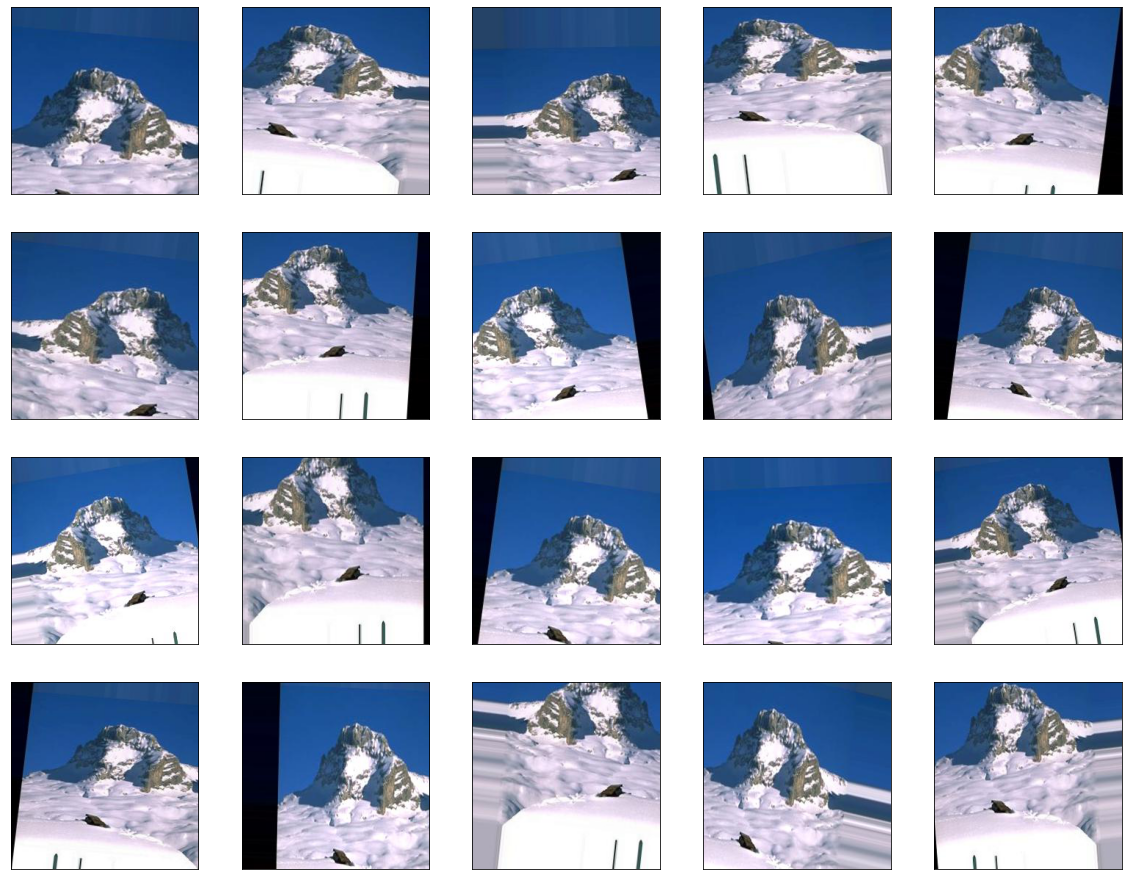

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
for i, a_img in enumerate(aug_imgs):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(a_img[0][0]/255.)

plt.show()

Now the real question is does any of this ultimately matter? Do these changes actually help our model's ability to learn and generalize better? Well, let's go ahead and run that experiment. 

-----

## Re-train your custom CNN model using the augment dataset

Now that we have created a data generator that creates augmented versions of the training images (and not the validation images). We can create a new instance of our custom CNN model with the same architecture, same parameters such as batch size and epochs and see if using augmented data helps. 

In [39]:
aug_model = create_model()

In [40]:
aug_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 16)        4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 43264)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)             

In [41]:
logdir = os.path.join("logs", "aug_model")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [42]:
train_data_gen_aug.samples

533

In [43]:
# Fit Model

epochs = 10

history = aug_model.fit(
    train_data_gen_aug,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    workers=14, # num should be 1 or 2 processors less than the total number of process on your machine 
    callbacks=[tensorboard_callback]
)

Epoch 1/10
32/32 [==============================] - 18s 520ms/step - loss: 0.7171 - accuracy: 0.7012 - val_loss: 1.4176 - val_accuracy: 0.6932
Epoch 2/10
32/32 [==============================] - 17s 526ms/step - loss: 0.4672 - accuracy: 0.8307 - val_loss: 0.5431 - val_accuracy: 0.7727
Epoch 3/10
32/32 [==============================] - 17s 511ms/step - loss: 0.2865 - accuracy: 0.9129 - val_loss: 0.3964 - val_accuracy: 0.8239
Epoch 4/10
32/32 [==============================] - 17s 503ms/step - loss: 0.2194 - accuracy: 0.9317 - val_loss: 0.2008 - val_accuracy: 0.9034
Epoch 5/10
32/32 [==============================] - 17s 502ms/step - loss: 0.3429 - accuracy: 0.8584 - val_loss: 0.6946 - val_accuracy: 0.8295
Epoch 6/10
32/32 [==============================] - 17s 512ms/step - loss: 0.2877 - accuracy: 0.9160 - val_loss: 0.2589 - val_accuracy: 0.9148
Epoch 7/10
32/32 [==============================] - 16s 501ms/step - loss: 0.2105 - accuracy: 0.9133 - val_loss: 0.2083 - val_accuracy: 0.9205

-----

# Compare Model Results

In [44]:
%load_ext tensorboard

%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 71471), started 1:12:08 ago. (Use '!kill 71471' to kill it.)

------

### Time for Questions 

Take a look at the `epoch_accuracy` plot and answer the following questions. 

Optionally move the `Smoothing` slider all the way to zero to view the raw scores. 

By the way, your results may look different than your classmates depending on how you choose to build your custom CNN model. 


**Question 1:** Which of the three models performed the best? 

YOUR ANSWER HERE

**Question 2:** Did augmenting the training data help our custom CNN model improve its score? If so why, if not why not?

YOUR ANSWER HERE

**Question 3:** Could one or more of the three models benefit from training on more than 10 epochs? If so why, if not why not?

YOUR ANSWER HERE

**Question 4:** If you didn't use regularization for you custom CNN, do you think the baseline model and the aug model could improve their scores if regularization was used? If so why, if not why not?

Consider reviewing your Sprint 2 Module Assginment 2 experimental results on regularization. 

YOUR ANSWER HERE

-----

# Resources and Stretch Goals

Stretch goals
- Enhance your code to use classes/functions and accept terms to search and classes to look for in recognizing the downloaded images (e.g. download images of parties, recognize all that contain balloons)
- Check out [other available pretrained networks](https://tfhub.dev), try some and compare
- Image recognition/classification is somewhat solved, but *relationships* between entities and describing an image is not - check out some of the extended resources (e.g. [Visual Genome](https://visualgenome.org/)) on the topic
- Transfer learning - using images you source yourself, [retrain a classifier](https://www.tensorflow.org/hub/tutorials/image_retraining) with a new category
- (Not CNN related) Use [piexif](https://pypi.org/project/piexif/) to check out the metadata of images passed in to your system - see if they're from a national park! (Note - many images lack GPS metadata, so this won't work in most cases, but still cool)

Resources
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) - influential paper (introduced ResNet)
- [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/) - an influential convolution based object detection system, focused on inference speed (for applications to e.g. self driving vehicles)
- [R-CNN, Fast R-CNN, Faster R-CNN, YOLO](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e) - comparison of object detection systems
- [Common Objects in Context](http://cocodataset.org/) - a large-scale object detection, segmentation, and captioning dataset
- [Visual Genome](https://visualgenome.org/) - a dataset, a knowledge base, an ongoing effort to connect structured image concepts to language